In [1]:
import pandas as pd                    # for data handling
import numpy as np                     # for random selections, mainly
import matplotlib.pyplot as plt        # for plotting
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
%matplotlib inline                  
plt.rcParams['figure.figsize'] = 7,7   # graph dimensions
plt.rcParams['font.size'] = 14  

In [2]:
dataset=pd.read_csv('positive.csv',names=['url'])
dataset['label']=1
dataset1=pd.read_csv('positive_unlabel.csv',names=['url'])
dataset1['label']=1
dataset2=pd.read_csv('unlabel.csv',names=['url'])
dataset2['label']=0
data=pd.concat([dataset,dataset1,dataset2]).reset_index(drop=True)
y=data['label']

In [3]:
y_orig=y.copy()

In [4]:
data.loc[500:999,'label']=0
y=data['label']

In [5]:
vectorizer = TfidfVectorizer(min_df = 0.0, analyzer="char", sublinear_tf=True, ngram_range=(1,3)) #converting data to vectors
X = vectorizer.fit_transform(data['url'].values.astype('U'))


In [6]:
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
X=svd.fit_transform(X) 
X = pd.DataFrame(X, columns = ['feature1', 'feature2'])

In [7]:
X.head()

,feature1,feature2
0,0.114241,0.153998
1,0.315280,0.062101
2,0.251538,0.123404
3,0.227589,0.096348
4,0.476117,-0.124364


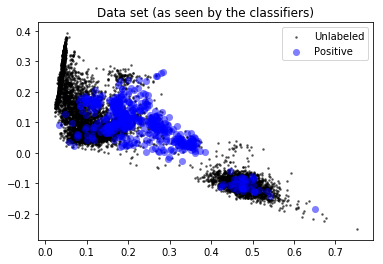

In [8]:
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c='k', marker='.', linewidth=1, s=10, alpha=0.5, 
    label='Unlabeled'
)
plt.scatter(
    X[y==1].feature1, X[y==1].feature2, 
    c='b', marker='o', linewidth=0, s=50, alpha=0.5, 
    label='Positive'
)
plt.legend()
plt.title('Data set (as seen by the classifiers)')
plt.show()

In [11]:
# We'll use a generic random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators = 1000,  # Use 1000 trees
    n_jobs = -1           # Use all CPU cores
)
rf.fit(X, y)

# Store the scores assigned by this approach
results = pd.DataFrame({
    'truth'      : y_orig,   # The true labels
    'label'      : y,        # The labels to be shown to models in experiment
    'output_std' : rf.predict_proba(X)[:,1]   # The random forest's scores
}, columns = ['truth', 'label', 'output_std'])

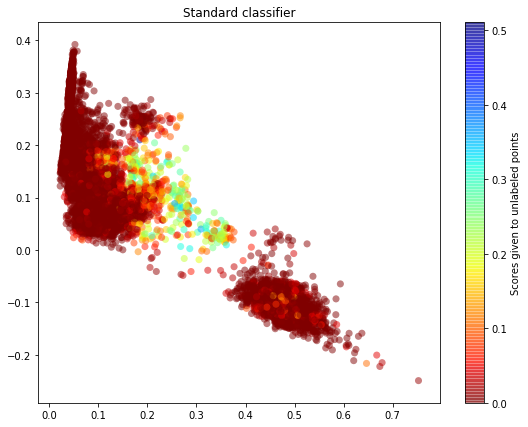

In [15]:
# Visualize this approach's results
plt.rcParams['figure.figsize'] = 9,7
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_std, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Standard classifier')
plt.show()

In [16]:
# Use 1000 trees
from sklearn.tree import DecisionTreeClassifier
n_estimators = 1000
estimator = DecisionTreeClassifier()

# Keep track of the indices of positive and unlabeled data points
iP = y[y > 0].index
iU = y[y <= 0].index

# For each data point, keep track of how many times it has been OOB...
num_oob = pd.DataFrame(np.zeros(shape = y.shape), index = y.index)

# ...and the sum of its OOB scores
sum_oob = pd.DataFrame(np.zeros(shape = y.shape), index = y.index)

for _ in range(n_estimators):
    # Get a bootstrap sample of unlabeled points for this round
    ib = np.random.choice(iU, replace=True, size = len(iP))

    # Find the OOB data points for this round
    i_oob = list(set(iU) - set(ib))

    # Get the training data (ALL positives and the bootstrap 
    # sample of unlabeled points) and build the tree
    Xb = X[y > 0].append(X.loc[ib])
    yb = y[y > 0].append(y.loc[ib])
    estimator.fit(Xb, yb)
    
    # Record the OOB scores from this round
    sum_oob.loc[i_oob, 0] += estimator.predict_proba(X.loc[i_oob])[:,1]
    num_oob.loc[i_oob, 0] += 1

# Finally, store the scores assigned by this approach
results['output_bag'] = sum_oob / num_oob

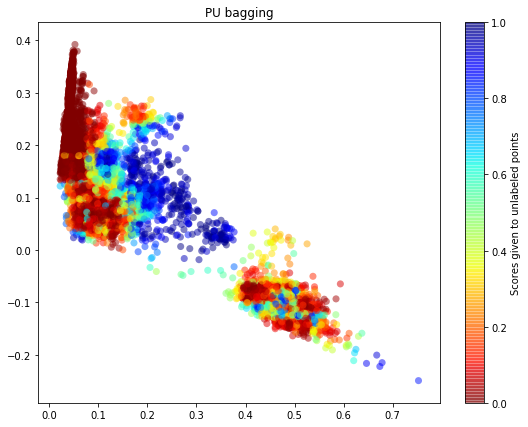

In [17]:
# Visualize this approach's results
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_bag, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('PU bagging')
plt.show()

In [19]:
from baggingPU import BaggingClassifierPU
bc = BaggingClassifierPU(
    DecisionTreeClassifier(), 
    n_estimators = 1000,  # 1000 trees as usual
    max_samples = sum(y), # Balance the positives and unlabeled in each bag
    n_jobs = -1           # Use all cores
)
bc.fit(X, y)
results['output_skb'] = bc.oob_decision_function_[:,1]

/Users/liuhan/pu_learning/baggingPU.py:593: RuntimeWarning: divide by zero encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


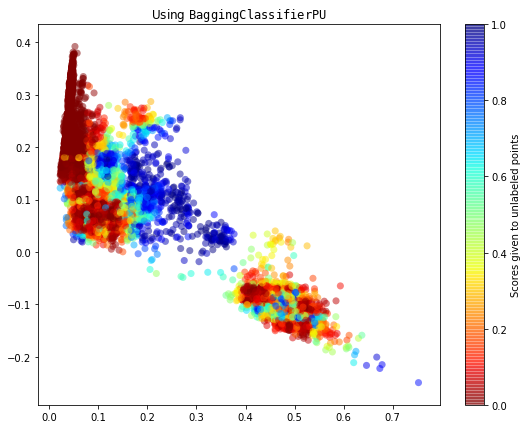

In [20]:
# Visualize this approach's results
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_skb, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title(r'Using ${\tt BaggingClassifierPU}$')
plt.show()

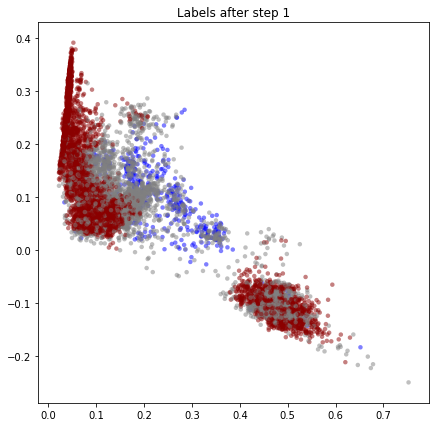

Step 1 labeled 0 new positives and 6524 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 626 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 182 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 85 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 61 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 41 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 34 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 28 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 23 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 18 new negatives.
Doing step 2... 

In [22]:
# Create a new target vector, with 1 for positive, -1 for unlabeled, and 
# 0 for "reliable negative" (there are no reliable negatives to start with)
ys = 2 * y - 1

# Get the scores from before
pred = rf.predict_proba(X)[:,1]

# Find the range of scores given to positive data points
range_P = [min(pred * (ys > 0)), max(pred * (ys > 0))]

# STEP 1
# If any unlabeled point has a score above all known positives, 
# or below all known positives, label it accordingly
iP_new = ys[(ys < 0) & (pred >= range_P[1])].index
iN_new = ys[(ys < 0) & (pred <= range_P[0])].index
ys.loc[iP_new] = 1
ys.loc[iN_new] = 0

# Show the results of step 1
plt.rcParams['figure.figsize'] = 7,7
cdict = {-1:'gray', 0:'darkred', 1:'blue'}
plt.scatter(
    X.feature1, X.feature2, 
    c = [cdict[k] for k in ys], 
    linewidth = 0, s = 20, alpha = 0.5
)
plt.title('Labels after step 1')
plt.show()   

# Classifier to be used for step 2
rf2 = RandomForestClassifier(n_estimators = 1000, n_jobs = -1)

# Limit to 10 iterations (this is arbitrary, but 
# otherwise this approach can take a very long time)
for i in range(10):
    # If step 1 didn't find new labels, we're done
    if len(iP_new) + len(iN_new) == 0 and i > 0:
        break
    
    print(
        'Step 1 labeled %d new positives and %d new negatives.' 
        % (len(iP_new), len(iN_new))
    )
    print('Doing step 2... ', end = '')
    
    # STEP 2
    # Retrain on new labels and get new scores
    rf2.fit(X, ys)
    pred = rf2.predict_proba(X)[:,-1]
    
    # Find the range of scores given to positive data points
    range_P = [min(pred * (ys > 0)), max(pred * (ys > 0))]
    
    # Repeat step 1
    iP_new = ys[(ys < 0) & (pred >= range_P[1])].index
    iN_new = ys[(ys < 0) & (pred <= range_P[0])].index
    ys.loc[iP_new] = 1
    ys.loc[iN_new] = 0
    
    
# Lastly, get the scores assigned by this approach    
results['output_stp'] = pred

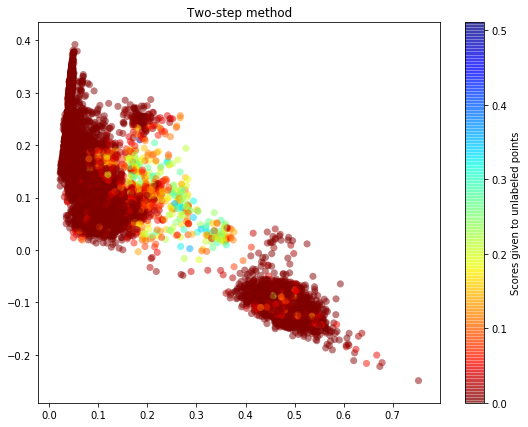

In [23]:
# Visualize this approach's final results
plt.rcParams['figure.figsize'] = 9,7
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_stp, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Two-step method')
plt.show()

In [25]:
# For each data point, calculate the average score from the three approaches
results['output_all'] = results[[
    'output_std', 'output_bag', 'output_stp'
]].mean(axis = 1)

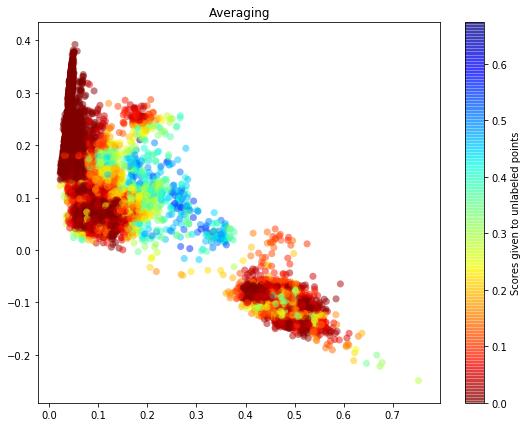

In [26]:
# Visualize average scores
plt.rcParams['figure.figsize'] = 9,7
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_all, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Averaging')
plt.show()

In [27]:
results[500:900]

,truth,label,output_std,output_bag,output_skb,output_stp,output_all
500,1,0,0.13500,0.974603,0.958071,0.13000,0.413201
501,1,0,0.20800,0.934942,0.955556,0.20200,0.448314
502,1,0,0.08400,0.915537,0.918432,0.06700,0.355512
503,1,0,0.10700,0.935079,0.944561,0.16500,0.402360
504,1,0,0.00100,0.374603,0.361522,0.00200,0.125868
505,1,0,0.00200,0.356021,0.371459,0.00400,0.120674
506,1,0,0.00000,0.019231,0.011591,0.00000,0.006410
507,1,0,0.18000,0.978970,0.956522,0.17200,0.443657
508,1,0,0.05100,0.902851,0.925769,0.04800,0.333950
509,1,0,0.18800,0.974843,0.962065,0.19400,0.452281
